In [1]:
# import tensorflow as tf
# from tensorflow import keras
# import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import re
import pyomo.environ as pyo
from mpl_toolkits import mplot3d
from useful import get_data, SVM_linear, SVM_nonlinear

In [179]:
up_data, up_t = get_data("up_data.txt")
circle_data, circle_t = get_data("circle_data.txt")
data = np.array([*up_data, *circle_data]).T
time_array = np.array([*up_t, *circle_t]).T

(d, N) = time_array.shape
N_h = N//2

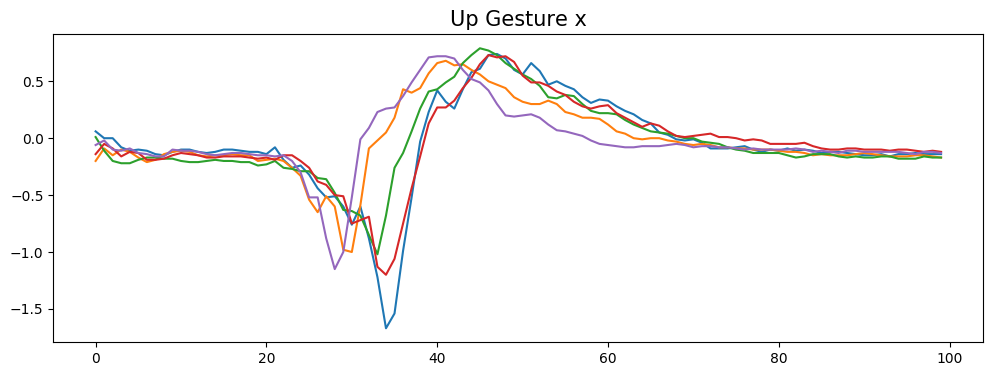

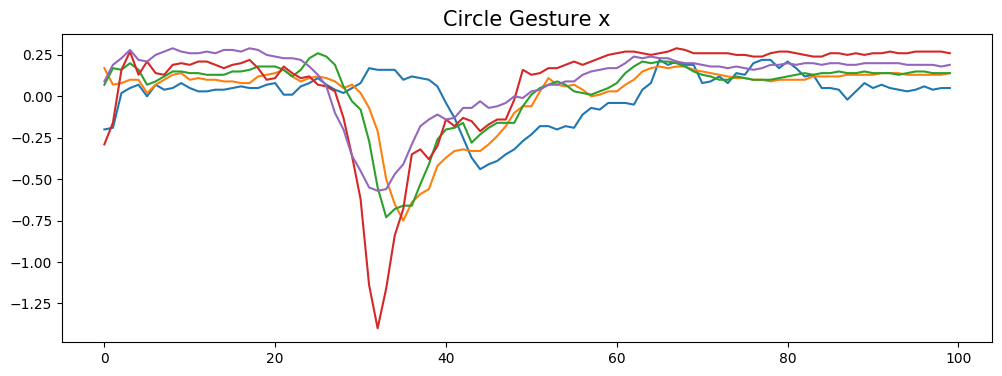

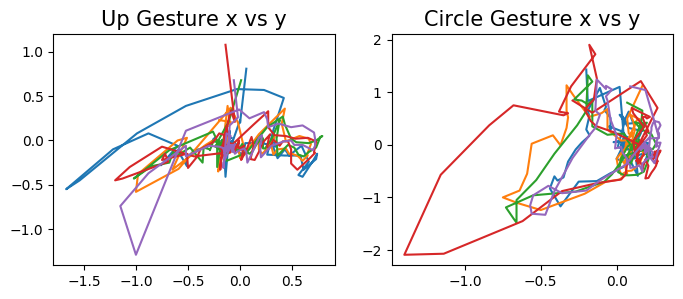

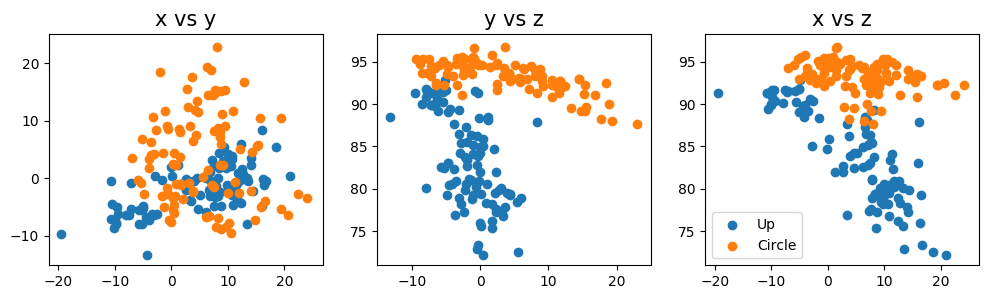

In [3]:
# Visualise data
plt.figure(figsize=(12, 4))
plt.title("Up Gesture x", fontsize=15)
plt.plot(data[:d, :5])
plt.show()

plt.figure(figsize=(12, 4))
plt.title("Circle Gesture x", fontsize=15)
plt.plot(data[:d, N_h:N_h+5])
plt.show()

fig, axs = plt.subplots(1, 2,  figsize=(8,3))
axs[0].set_title("Up Gesture x vs y", fontsize=15)
axs[0].plot(data[:d, :5], data[d:2*d, :5])
axs[1].set_title("Circle Gesture x vs y", fontsize=15)
axs[1].plot(data[:d, N_h:N_h+5], data[d:2*d, N_h:N_h+5])
plt.show()

fig, axs = plt.subplots(1, 3,  figsize=(12,3))
axs[0].set_title("x vs y", fontsize=15)
axs[0].scatter(data[:d, :N_h].sum(axis=0), data[d:2*d, :N_h].sum(axis=0), label="Up")
axs[0].scatter(data[:d, N_h:N].sum(axis=0), data[d:2*d, N_h:N].sum(axis=0), label="Circle")
axs[1].set_title("y vs z", fontsize=15)
axs[1].scatter(data[d:2*d, :N_h].sum(axis=0), data[2*d:3*d, :N_h].sum(axis=0), label="Up")
axs[1].scatter(data[d:2*d, N_h:N].sum(axis=0), data[2*d:3*d, N_h:N].sum(axis=0), label="Circle")
axs[2].set_title("x vs z", fontsize=15)
axs[2].scatter(data[:d, :N_h].sum(axis=0), data[2*d:3*d, :N_h].sum(axis=0), label="Up")
axs[2].scatter(data[:d, N_h:N].sum(axis=0), data[2*d:3*d, N_h:N].sum(axis=0), label="Circle")
plt.legend()
plt.show()

w =  [[0.41549386 1.55476302]]
b =  [-39.07477202]


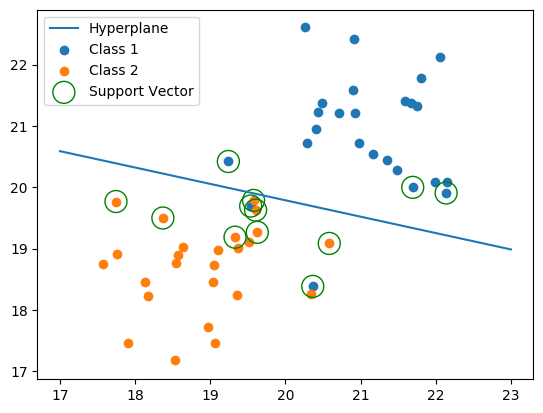

In [180]:
# Test SVM

# Generate data
t = np.array([*[1]*25, *[-1]*25])
x_test = np.random.normal(0, 0.8, (50, 2)) + t.reshape((50, 1)) + 20

# Learn SVM
w, b, svi = SVM_linear(x_test, t, C=10)

print("w = ", w)
print("b = ", b)

# Plot results
x_axis_values = np.linspace(17, 23, 50)
plt.scatter(x_test[:25, 0], x_test[:25, 1], label="Class 1")
plt.scatter(x_test[25:50, 0], x_test[25:50, 1], label="Class 2")
plt.scatter(x_test[svi, 0], x_test[svi, 1], label="Support Vector", s=250, facecolors='none', edgecolors='green')
plt.plot(x_axis_values, - (x_axis_values*w[0, 0] + b) / w[0, 1], label="Hyperplane")
plt.legend()
plt.show()

In [204]:
# Condense and format feature data
def get_features(data, time_array):
    """Given raw data, create feature vector."""
    N_t, N = data.shape[0]//3, data.shape[1]

    # Raw acceleration values
    ax, ay, az = data[:N_t, :], data[N_t:N_t*2, :], data[N_t*2:N_t*3, :]

    # # Differentiate
    # dax = (ax[1:] - ax[:99]) / (time_array[1:] - time_array[:99])
    # day = (ay[1:] - ay[:99]) / (time_array[1:] - time_array[:99])
    # daz = (az[1:] - az[:99]) / (time_array[1:] - time_array[:99])

    # Integrate
    def integrate(x, t):
        """Integrage Using trapezoid Rule."""
        x_i = np.zeros(x.shape)
        x_i[:-1] = (t[1:] - t[:-1]) * (x[:-1] + x[1:]) / 2
        x_i = np.cumsum(x_i, axis=0)
        x_i[-1] = 2*x_i[-2] - x_i[-3]
        return x_i

    vx = integrate(ax, time_array)
    x = integrate(vx, time_array)
    vy = integrate(ay, time_array)
    y = integrate(vy, time_array)
    vz = integrate(az, time_array)
    z = integrate(vz, time_array)


    # plt.title("ax Raw")
    # plt.plot(time_array[:, :5], ax[:, :5])
    # plt.show()

    # plt.title("vx")
    # plt.plot(time_array[:, :5], vx[:, :5])
    # plt.show()

    # plt.title("x")
    # plt.plot(time_array[:, :5], x[:, :5])
    # plt.show()

    # plt.title("x, up")
    # plt.plot(time_array[:, :5], x[:, 51:56])
    # plt.show()

    def get_dist(x, r, bins=100):
        dist = np.zeros((bins, N))
        for i in range(N):
            dist[:, i] = np.histogram(x[:, i], bins=bins, range=r)[0]
        return dist

    # # ax Distributions
    # ax_dist_vals = np.linspace(-1.7, 0.8, 20)
    # ax_dist = get_dist(ax, r=(-1.7, 0.8))

    # # vx Distributions
    # vx_dist_vals = np.linspace(-0.25, 0.05, 20)
    # vx_dist = get_dist(vx, r=(-0.25, 0.05))

    # # x Distributions
    # x_dist_vals = np.linspace(-0.15, 0.1, 20)
    # x_dist = get_dist(x, r=(-0.15, 0.1))
    
    X = np.array([
        ax.sum(axis=0),
        ay.sum(axis=0),
        az.sum(axis=0),
        vx.sum(axis=0),
        vy.sum(axis=0),
        vz.sum(axis=0),
        x.sum(axis=0),
        y.sum(axis=0),
        z.sum(axis=0),

        ax.max(axis=0),
        ay.max(axis=0),
        az.max(axis=0),
        vx.max(axis=0),
        vy.max(axis=0),
        vz.max(axis=0),
        x.max(axis=0),
        y.max(axis=0),
        z.max(axis=0),

        ax.min(axis=0),
        ay.min(axis=0),
        az.min(axis=0),
        vx.min(axis=0),
        vy.min(axis=0),
        vz.min(axis=0),
        x.min(axis=0),
        y.min(axis=0),
        z.min(axis=0),
        # *ax_dist,
        # *x_dist,
        # *vx_dist,
    ]).T
    return X
X = get_features(data, time_array)
t = np.array([*[1]*N_h, *[-1]*N_h])
print(X.shape)
print(t.shape)

(200, 27)
(200,)


In [205]:
# Learn SVM
# w, b, svi = SVM_linear(X, t, C=10)
print("w = ", w[0].tolist())
print("b = ", b)

w =  [-0.1458796546321565, 0.07957451934207162, -0.3099446730427705, 0.22961725219563314, -0.07180242531998897, -0.06897685526242402, -0.19272214731628637, -0.1064572406004928, 0.2007663133519905, 0.08872114087570375, -0.3271642333630433, 0.42172981032096857, 0.00639833633217492, -0.014472203705687773, -0.004649166695766245, 0.01619569516744637, -0.0070773448159847435, -0.0011365327983656175, -0.08028048923436046, 0.2476493987128864, -0.12467462321793095, 0.0031928511719578503, 0.010210959725573001, -0.0005101402267897172, -0.012506988573161565, 0.004980222586178393, -1.1767255350855389e-05]
b =  [24.18716052]


86.7


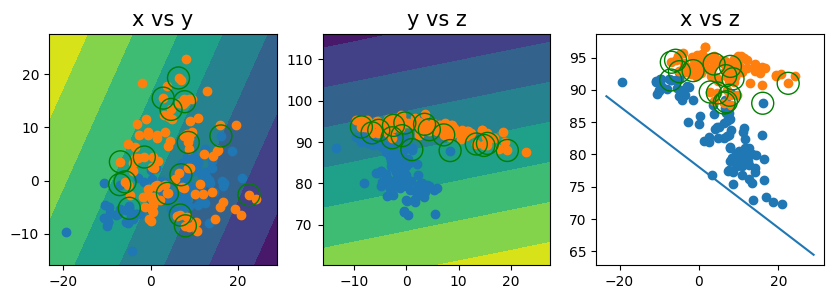

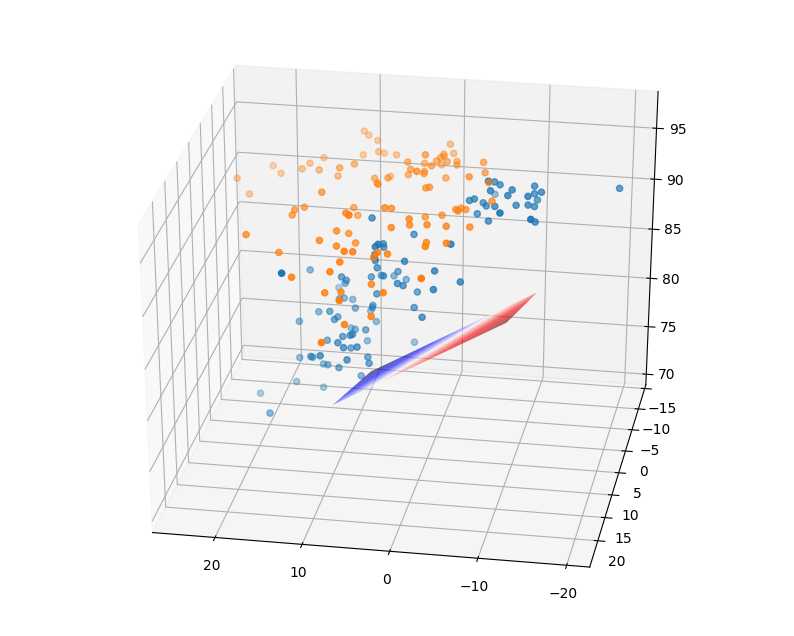

In [206]:
%matplotlib inline
# Plot separating hyperplane
from time import sleep

scale = 1.2
line_x = np.linspace(X[:, 0].min()*scale, X[:, 0].max()*scale, N)
line_y = np.linspace(X[:, 1].min()*scale, X[:, 1].max()*scale, N)
line_z = np.linspace(X[:, 2].min()/scale, X[:, 2].max()*scale, N)
print(X[:, 2].min()*scale)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].set_title("x vs y", fontsize=15)
X_grid, Y_grid = np.meshgrid(line_x, line_y)
axs[0].contourf(X_grid, Y_grid, X_grid * w[0, 0] + Y_grid * w[0, 1] + b)
axs[0].scatter(X[:N_h, 0], X[:N_h, 1], label="Up")
axs[0].scatter(X[N_h:N, 0], X[N_h:N, 1], label="Circle")
axs[0].scatter(X[svi, 0], X[svi, 1], label="Support Vector", s=250, facecolors='none', edgecolors='green')
# axs[0].plot(line_x, - (line_x * w[0, 0] + b) / w[0, 1])

# axs[0].set_ylim(-20, 10)

axs[1].set_title("y vs z", fontsize=15)
Y_grid, Z_grid = np.meshgrid(line_y, line_z)
axs[1].contourf(Y_grid, Z_grid, Y_grid * w[0, 1] + Z_grid * w[0, 2] + b)
axs[1].scatter(X[:N_h, 1], X[:N_h, 2], label="Up")
axs[1].scatter(X[N_h:N, 1], X[N_h:N, 2], label="Circle")
# axs[1].plot(line_y, - (line_y * w[0, 1] + b) / w[0, 2])
axs[1].scatter(X[svi, 1], X[svi, 2], label="Support Vector", s=250, facecolors='none', edgecolors='green')
# axs[1].set_ylim(-20, 10)

axs[2].set_title("x vs z", fontsize=15)
axs[2].scatter(X[:N_h, 0], X[:N_h, 2], label="Up")
axs[2].scatter(X[N_h:N, 0], X[N_h:N, 2], label="Circle")
axs[2].plot(line_x, - (line_x * w[0, 0] + b) / w[0, 2])
axs[2].scatter(X[svi, 0], X[svi, 2], label="Support Vector", s=250, facecolors='none', edgecolors='green')
# axs[2].set_ylim(80, 100)
plt.show()


# 3D Plot 
x_surface = np.outer(np.linspace(-10, 10, 50), np.ones(50)) 
y_surface = x_surface.copy().T
z_surface = - (x_surface * w[0, 0] + y_surface * w[0, 1] + b) / w[0, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(X[:N_h, 0], X[:N_h, 1], X[:N_h, 2])
ax.scatter(X[N_h:N, 0], X[N_h:N, 1], X[N_h:N, 2])
ax.plot_surface(x_surface, y_surface, z_surface, cmap='seismic', alpha=0.8)
ax.view_init(30, 100)
plt.show()

# This is a useful rotation animation but will destroy the computer
# hfig = display(fig, display_id=True)
# for angle in range(50, 360):
#     ax.view_init(30, 2*angle)
#     fig.canvas.draw()
#     hfig.update(fig)
#     sleep(0.001)

In [210]:
def test_SVM(X, t, w, b):
    (N, d) = X.shape
    y = np.dot(w, X.T) + b
    for i in range(N):
        print("Outcome: ", y[0, i]*t[i])
    errors = [1 if y[0, i]*t[i] < 0 else 0 for i in range(N)]
    print("Samples Tested: ", N)
    print("Total Errors: ", sum(errors))
    print("Accuracy: ", (N - sum(errors))/N)

In [211]:
up_test_data, up_t = get_data("up_test_data.txt")
circle_test_data, circle_t = get_data("circle_test_data.txt")
test_data = np.array([*up_test_data, *circle_test_data]).T
test_time_array = np.array([*up_t, *circle_t]).T
test_time_array = (test_time_array - test_time_array[0, :]) / 1000

(test_d, test_N) = test_time_array.shape
test_N_h = test_N//2

test_t = np.array([*[1]*test_N_h, *[-1]*test_N_h])

In [212]:
X_test = get_features(test_data, test_time_array)
test_SVM(X_test, test_t, w, b)

Outcome:  0.6475032779185277
Outcome:  1.2726613017101585
Outcome:  2.1207555148749933
Outcome:  2.2841913943685093
Outcome:  3.056520150660827
Outcome:  2.0601971076272427
Outcome:  2.222805770132343
Outcome:  2.3173620975249953
Outcome:  3.8799026331593645
Outcome:  3.5156145702322625
Outcome:  2.4638472588933986
Outcome:  3.7686643097848247
Outcome:  3.4583364295778907
Outcome:  3.7872242956914057
Outcome:  3.6187029225786134
Outcome:  3.841845732181085
Outcome:  3.9818673942183906
Outcome:  4.455133623063816
Outcome:  3.6899868480093865
Outcome:  4.6105707210763605
Outcome:  3.9782095565215734
Outcome:  3.8286886798601607
Outcome:  2.2015563634832915
Outcome:  2.9522754722183464
Outcome:  4.094561341696057
Outcome:  1.6302544816043998
Outcome:  2.185792791418809
Outcome:  1.7947481639912688
Outcome:  2.5563998017920646
Outcome:  2.7587725032402055
Outcome:  3.1158728052822475
Outcome:  3.403709342401026
Outcome:  2.799749122649871
Outcome:  2.05487564710117
Outcome:  1.612303874634

In [187]:
K = lambda Xn, Xm, gam=0.01: pyo.exp(-gam * np.linalg.norm(Xn - Xm)**2)
K_pred = lambda Xn, Xm, gam=0.01: np.exp(-gam * np.linalg.norm(Xn - Xm, axis=1)**2)
a, b, svi = SVM_nonlinear(X, t, K, C=10)

In [188]:
def test_nonlinear_SVM(X_test, test_t, X, t, a, b):
    (N_test, d) = X_test.shape
    N = X.shape[0]
    y = np.zeros(N_test)
    for n in range(N):
        y += a[n] * t[n] * K_pred(X[n], X_test)
    errors = [1 if y[i]*test_t[i] < 0 else 0 for i in range(N_test)]
    print("Samples Tested: ", N_test)
    print("Total Errors: ", sum(errors))
    print("Accuracy: ", (N - sum(errors))/N)

test_nonlinear_SVM(X_test, test_t, X, t, a, b)
print(a)

Samples Tested:  100
Total Errors:  11
Accuracy:  0.945
[10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001 10.0000001
 10.00

In [198]:
# Test and visualise the nonlinear SVM
K = lambda Xn, Xm, gam=0.01: pyo.exp(-gam * np.linalg.norm(Xn - Xm)**2)
K_pred = lambda Xn, Xm, gam=0.01: np.exp(-gam * np.linalg.norm(Xn - Xm, axis=1)**2)

n = 100
n_h = n // 2
t = np.array([*[1]*n_h, *[-1]*n_h])
x_test = np.random.normal(0, 0.8, (n, 2)) + t.reshape((n, 1)) + 20
a, b, svi = SVM_nonlinear(x_test, t, K, C=10)
print(x_test.shape)

n_contour = 100
x_line = np.linspace(16, 24, n_contour)
y_line = np.linspace(16, 24, n_contour)

X_grid, Y_grid = np.meshgrid(x_line, y_line)
z = np.zeros((n_contour, n_contour))
for n in range(n_contour):
    for m in range(n_contour):
        for k in range(50):
            z[n, m] += a[k] * t[k] * K(np.array([X_grid[n, m], Y_grid[n, m]]), x_test[k])

(100, 2)


Samples Tested:  100
Total Errors:  6
Accuracy:  0.94


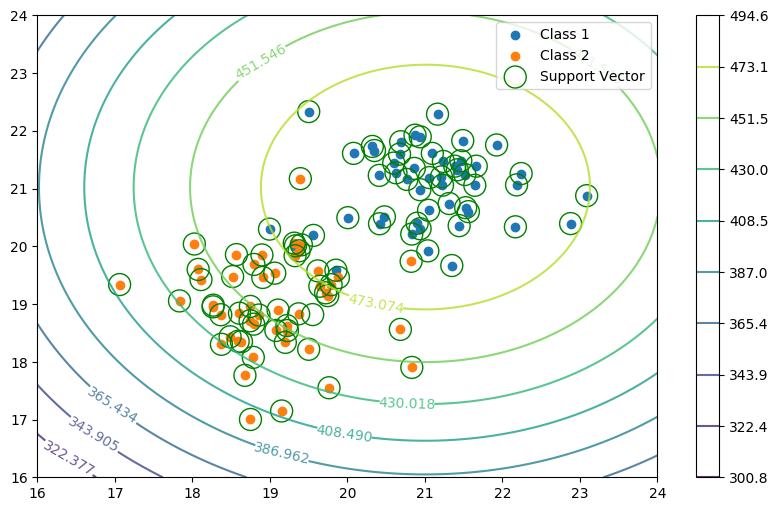

In [199]:
test_nonlinear_SVM(x_test, t, x_test, t, a, b)

plt.figure(figsize=(10, 6))
CS = plt.contour(X_grid, Y_grid, z, levels=np.linspace(z.min(), z.max(), 10), alpha=0.8)
plt.clabel(CS, inline=1, fontsize=10)
plt.colorbar(CS)
plt.scatter(x_test[:n_h, 0], x_test[:n_h, 1], label="Class 1")
plt.scatter(x_test[n_h:n, 0], x_test[n_h:n, 1], label="Class 2")
plt.scatter(x_test[svi, 0], x_test[svi, 1], label="Support Vector", s=250, facecolors='none', edgecolors='green')
plt.legend()
plt.show()

In [197]:
a

array([10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001,
       10000.0001, 10000.0001, 10000.0001, 10000.0001, 10000.0001])